# <center>Projet Topic Modeling</center>

During the Natural Language Processing course, text representation algorithms have been introduced. However they don't suffice to the creation of complete NLP systems.

Most of them usually rely on text pre-processing at first -- in other words, they rely on a specific data pipeline that is tied to the final task you are trying to solve.

As a result, we will try in this notebook to create a pipeline from scratch given a specific final task.

# Exploring the dataset

In [1]:
import pandas as pd
import numpy as np
import nltk

import itertools
import itertools
import os
import re
import secrets
import string
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style

import pandas as pd
import spacy

from itertools import chain

from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, Phrases, KeyedVectors
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from nltk.corpus import wordnet
# from pattern.en import pluralize, singularize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm
from wordcloud import WordCloud
from nltk.corpus import stopwords

from spacy.parts_of_speech import IDS as POS_map

You can load the dataset using pandas and the [.read_json()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_json.html) method. Try loading your dataset here:

In [2]:
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})

------

A good way to get the grasp of your corpus is to count the occurences of words across it. For convenience, we've defined a dummy function that splits words by checking where spaces are and... Simply that. This is the most basic form of word identification in text that could be used.

In [3]:
def dummy_word_split(texts):
    """Function identifying words in a sentence in a really dummy way.
        
        Argument:
            - texts (list of str): a list of raw texts in which we'd like to identify words
            
        Return:
            - list of list containing each word separately.
    """
    texts_out = []
    for text in texts:
        texts_out.append(text.split(" "))
        
    return texts_out

In [4]:
splitted_texts = dummy_word_split(dataset["headline"].tolist())

In [5]:
splitted_texts[0] + splitted_texts[1]

['There',
 'Were',
 '2',
 'Mass',
 'Shootings',
 'In',
 'Texas',
 'Last',
 'Week,',
 'But',
 'Only',
 '1',
 'On',
 'TV',
 'Will',
 'Smith',
 'Joins',
 'Diplo',
 'And',
 'Nicky',
 'Jam',
 'For',
 'The',
 '2018',
 'World',
 "Cup's",
 'Official',
 'Song']

Now, let's define a function that counts word occurences and highlight what are the most important words of our corpus:

In [6]:
def compute_word_occurences(texts):
    """You have to define this function yourself. """
    
    words = itertools.chain.from_iterable(texts)
    
    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})

    return word_count

Once this is done, display the top 20 most occuring words in your texts.

In [7]:
compute_word_occurences(splitted_texts).head(1000)

,Word,Count
0,The,47803
1,To,38569
2,A,24839
3,In,24141
4,Of,22956
...,...,...
995,Father's,258
996,Netflix,258
997,Park,258
998,Culture,257


Does it make sense, and can you leverage such results?

# Actual pipeline

As you have seen above, the results obtained from a simple word count aren't so great. Similar words doesn't add up (such as run and running), and you have a lot of noise included. Words such as *the*, *you*, *an* could be removed for instance.

Actually, a lot can be done. Let's check that out.

----------

## What does the pipeline look like?

A NLP data pipeline often relies on the following elements. Some can be added, some can be removed, but they all look like this at some point:

1. **Ensuring data quality.** You have to make sure that there's no N/A in your data and that everything is in the good format shape. Having this as the entrance of your pipeline will save you a lot of time in the long run, so try defining it thoroughly.


2. **Filtering texts from unwanted characters**. Especially if you get data from web, you'll end up with HTML tags or encoding stuff that you don't need in your texts. Before applying anything to them, you need to get them cleaned up. Here, try removing the dates and the punctuation for instance.


3. **Unify your texts**. (*This is topic modeling specific*). You don't want to make the difference between a word at the beginning of a phrase of in the middle of it here. You should unify all your words by lowercasing them and deaccenting them as well.


4. **Converting sentences to lists of words**. Some words aren't needed for our analyses, such as *your*, *my*, etc. In order to remove them easily, you have to convert your sentences to lists of words. You can use the dummy function defined above but I'd advised against it. Try finding a function that does that smoothly in [gensim.utils](https://radimrehurek.com/gensim/utils.html)!


5. **Remove useless words**. You need to remove useless words from your corpus. You have two approaches: [use a hard defined list of stopwords](https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/) or rely on TF-IDF to identify useless words. The first is the simplest, the second might yield better results!


6. **Creating n-grams**. If you look at New York, it is composed of two words. As a result, a word count wouldn't really return a true count for *New York* per se. In NLP, we represent New York as New_York, which is considered a single word. The n-gram creation consists in identifying words that occur together often and regrouping them. It boosts interpretability for topic modeling in this case.


7. **Stemming / Lemmatization**. Shouldn't run, running, runnable be grouped and counted as a single word when we're identifying discussion topics? Yes, they should. Stemming is the process of cutting words to their word root (run- for instance) quite brutally while lemmatization will do the same by identifying the kind of word it is working on. You should convert the corpus words into those truncated representations to have a more realistic word count.


8. **Part of speech tagging**. POS helps in the identification of verbs, nouns, adjectives, etc. For topic models, it is a good idea to work only on verbs and nouns. Adjectives don't convey info about the actual underlying topic discussed at hand.

## Let's create it!

Now it's your turn. Try to implement each step of the pipeline, and compare the word counts obtained earlier and the one obtained after preprocessing your texts.

### Ensuring data quality

In [8]:
def check_data_quality(texts):
    """Check wheter all the dataset is conform to the expected behaviour."""
    assert all([isinstance(t, str) for t in texts]), "Input data contains something different than strings."
    assert all([t != np.nan for t in texts]), "Input data contains NaN values."
    
    return True

In [9]:
def force_format(texts):
    return [str(t) for t in texts]

In [10]:
texts = force_format(dataset["headline"])

In [11]:
print(f"Is the dataset passing our data quality check?\n{check_data_quality(texts)}")

Is the dataset passing our data quality check?
True


### Filtering texts

https://regex101.com/

In [12]:
def filter_text(texts_in):
    """Removes incorrect patterns from a list of texts, such as hyperlinks, bullet points and so on"""
    
    texts_out = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', texts_in, flags=re.MULTILINE)
    texts_out = re.sub(r'[(){}\[\]<>]', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&amp;#.*;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&gt;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'â€™', "'", texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'\s+', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&#x200B;', ' ', texts_out, flags=re.MULTILINE)
    # Mail regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r"(?i)(?:[a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`{|}~-]+)*|\"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*\")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', texts_out, flags=re.MULTILINE)
    # Phone regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r".*?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}).*?", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', texts_out, flags=re.MULTILINE)
    # Remove names in twitter
    texts_out = re.sub(r'@\S+( |\n)', '', texts_out, flags=re.MULTILINE)

    # Remove starts commonly used on social media
    texts_out = re.sub(r'\*', '', texts_out, flags=re.MULTILINE)
    return texts_out


In [13]:
texts = [filter_text(t) for t in texts]

### Unifying texts & converting sentences to list of words

In [14]:
def sent_to_words(sentences):
    """Converts sentences to words.

    Convert sentences in lists of words while removing the accents and the punctuation.

    @param:
        sentences: a list of strings, the sentences we want to convert
    @return
        A list of words' lists.
    """
    for sentence in tqdm(sentences):
        yield (simple_preprocess(str(sentence), deacc=True))


In [15]:
texts = list(sent_to_words(texts))

100%|███████████████████████████████████████████████████████████████████████| 200853/200853 [00:06<00:00, 32090.17it/s]


In [16]:
texts

[['there',
  'were',
  'mass',
  'shootings',
  'in',
  'texas',
  'last',
  'week',
  'but',
  'only',
  'on',
  'tv'],
 ['will',
  'smith',
  'joins',
  'diplo',
  'and',
  'nicky',
  'jam',
  'for',
  'the',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'for', 'the', 'first', 'time', 'at', 'age'],
 ['jim',
  'carrey',
  'blasts',
  'castrato',
  'adam',
  'schiff',
  'and',
  'democrats',
  'in',
  'new',
  'artwork'],
 ['julianna',
  'margulies',
  'uses',
  'donald',
  'trump',
  'poop',
  'bags',
  'to',
  'pick',
  'up',
  'after',
  'her',
  'dog'],
 ['morgan',
  'freeman',
  'devastated',
  'that',
  'sexual',
  'harassment',
  'claims',
  'could',
  'undermine',
  'legacy'],
 ['donald',
  'trump',
  'is',
  'lovin',
  'new',
  'mcdonald',
  'jingle',
  'in',
  'tonight',
  'show',
  'bit'],
 ['what',
  'to',
  'watch',
  'on',
  'amazon',
  'prime',
  'that',
  'new',
  'this',
  'week'],
 ['mike',
  'myers',
  'reveals',
  'he',
  'like',
  'to',

## Remove useless words

In [17]:
en_stops = set(stopwords.words('english'))

## TF-IDF pour identifier les stopwords
tvec = TfidfVectorizer(min_df=.0025, max_df=.1, stop_words=en_stops, ngram_range=(1,1))
tvec_weights = tvec.fit_transform(dataset['headline'].dropna())
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
weights_df.sort_values(by='weight', ascending=False).head(20)

## Liste pré-définis de stopwords à éliminer
for lists in texts:
    for word in en_stops:
        try:
            lists.remove(word)
        except Exception as e:
            e =""

### COMPTER LES MOTS A LA FIN DES DEUX METHODES ET LES COMPARER

C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:
texts

[['mass', 'shootings', 'texas', 'last', 'week', 'tv'],
 ['smith',
  'joins',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'first', 'time', 'age'],
 ['jim',
  'carrey',
  'blasts',
  'castrato',
  'adam',
  'schiff',
  'democrats',
  'new',
  'artwork'],
 ['julianna',
  'margulies',
  'uses',
  'donald',
  'trump',
  'poop',
  'bags',
  'pick',
  'dog'],
 ['morgan',
  'freeman',
  'devastated',
  'sexual',
  'harassment',
  'claims',
  'could',
  'undermine',
  'legacy'],
 ['donald',
  'trump',
  'lovin',
  'new',
  'mcdonald',
  'jingle',
  'tonight',
  'show',
  'bit'],
 ['watch', 'amazon', 'prime', 'new', 'week'],
 ['mike', 'myers', 'reveals', 'like', 'fourth', 'austin', 'powers', 'film'],
 ['watch', 'hulu', 'new', 'week'],
 ['justin', 'timberlake', 'visits', 'texas', 'school', 'shooting', 'victims'],
 ['south',
  'korean',
  'president',
  'meets',
  'north',
  'korea',
  'kim',
  'jong',
  'un',
  'talk',
  'trump',
  'su

### Creating n-grams

In [19]:
def create_bigrams(texts, bigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify bigrams in texts and return the texts with bigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))
    
    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))
    
    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]

def create_trigrams(texts, trigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify trigrams in texts and return the texts with trigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))
    
    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))
    
    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]


In [20]:
texts = create_bigrams(texts)

In [21]:
texts

['mass_shootings texas last week tv',
 'smith joins diplo nicky jam world_cup official song',
 'hugh grant marries first_time age',
 'jim_carrey blasts castrato adam schiff democrats new artwork',
 'julianna margulies uses donald_trump poop bags pick dog',
 'morgan_freeman devastated sexual_harassment claims could undermine legacy',
 'donald_trump lovin new mcdonald jingle tonight_show bit',
 'watch amazon prime new week',
 'mike myers reveals like fourth austin powers film',
 'watch hulu new week',
 'justin_timberlake visits texas school_shooting victims',
 'south_korean president meets north_korea kim_jong un talk trump summit',
 'way life risk remote oyster growing region called robots',
 'trump crackdown immigrant parents puts kids already strained system',
 'trump son concerned fbi obtained wiretaps putin ally met trump_jr',
 'edward_snowden one trump loves vladimir_putin',
 'booyah obama photographer hilariously trolls trump spy claim',
 'ireland votes repeal abortion amendment l

### Stemming / Lemmatization & Part-of-Speech filtering

In [22]:
def lemmatize_texts(texts, 
                    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], 
                    forbidden_postags=[], 
                    as_sentence=False, 
                    get_postags=False, 
                    spacy_model=None):
    """Lemmatize a list of texts.
    
            Please refer to https://spacy.io/api/annotation for details on the allowed
        POS tags.
        @params:
            - texts_in: a list of texts, where each texts is a string
            - allowed_postags: a list of part of speech tags, in the spacy fashion
            - as_sentence: a boolean indicating whether the output should be a list of sentences instead of a list of word lists
        @return:
            - A list of texts where each entry is a list of words list or a list of sentences
        """
    texts_out = []
    
    if allowed_postags and forbidden_postags:
        raise ValueError("Can't specify both allowed and forbidden postags")

    if forbidden_postags:
        allowed_postags = list(set(POS_map.keys()).difference(set(forbidden_postags)))

    if not spacy_model:
        print("Loading spacy model")
        spacy_model = spacy.load('en_core_web_md')

    print("Beginning lemmatization process")
    total_steps = len(texts)

    docs = spacy_model.pipe(texts)

    for i, doc in tqdm(enumerate(docs), total=total_steps):
        if get_postags:
            texts_out.append(["_".join([token.lemma_, token.pos_]) for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags])
    
    if as_sentence:
        texts_out = [" ".join(text) for text in texts_out]
        
    return texts_out

In [23]:
l_texts = lemmatize_texts(texts[:1000],
                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'X', 'PROPN'], 
                get_postags=False)

Loading spacy model


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Beginning lemmatization process


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 542.76it/s]


In [24]:
str1 = ""
for text in l_texts:
    str1 += " ".join(text)
    str1 += " /£$/ " 
l_texts = str1.split(" /£$/ ")
l_texts

['mass_shooting texas last week tv',
 'smith join diplo nicky jam world_cup official song',
 'hugh grant marrie first_time age',
 'jim_carrey blast castrato adam schiff democrats new artwork',
 'julianna margulies use donald_trump poop bag pick dog',
 'morgan_freeman devastate sexual_harassment claim undermine legacy',
 'donald_trump lovin new mcdonald jingle tonight_show bit',
 'watch amazon prime new week',
 'mike myers reveal fourth austin power film',
 'watch hulu new week',
 'justin_timberlake visit texas school_shoote victim',
 'south_korean president meet north_korea kim_jong un talk trump summit',
 'way life risk remote oyster grow region call robot',
 'trump crackdown immigrant parent put kid already strain system',
 'trump son concern fbi obtain wiretap putin ally meet trump_jr',
 'edward_snowden trump love vladimir_putin',
 'booyah obama photographer hilariously troll trump spy claim',
 'ireland vote repeal abortion amendment landslide referendum',
 'ryan_zinke look reel bac

## Vectorization

In [25]:
vectorized_texts = l_texts
vect = CountVectorizer(stop_words='english')
vect_text = vect.fit_transform(vectorized_texts)
print(vect_text.shape)

(1001, 3077)


## Latent Dirichlet Allocation

Nous allons utiliser LDA qui est un type de Machine Learning non supervisé (ce qu'on recherche dans notre cas).

Nous pouvons voir les mots les plus fréquents et les plus rares dans les titres des nouvelles en fonction du score idf. Plus la valeur est faible, plus le mot est fréquent dans les titres de l'actualité.

### Déterminer le meilleur modèle LDA

On va définir nos paramètres de recherche, initialiser le modèle et la classe de Grid Search puis faire la Grid Search.

In [27]:
search_params = {'n_components': [10, 20, 30, 40, 50], 
                 'learning_decay': [.5, .7, .9]}
lda = LDA()
model = GridSearchCV(lda, param_grid=search_params)
model.fit(vect_text)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 20, 30, 40, 50]})

Affichage du meilleur modèle avec ses meilleurs paramètres associés.

In [28]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(vect_text))

Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -22538.80953952148
Model Perplexity:  5824.459931732239


### Evalutation du modèle

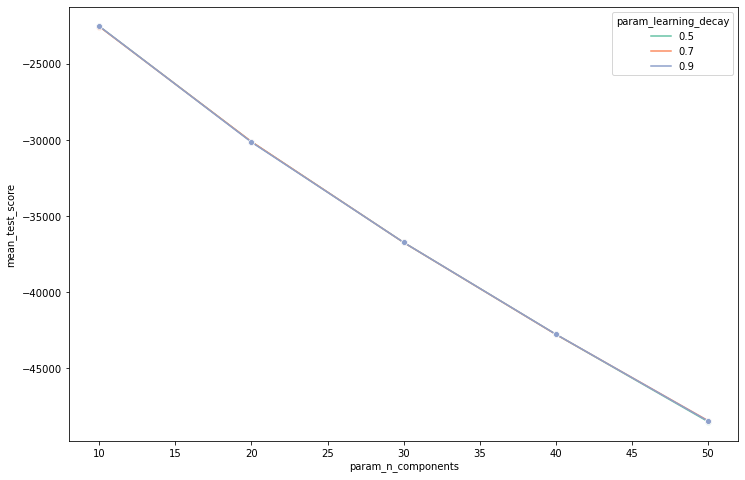

In [29]:
import seaborn as sns

results = pd.DataFrame(model.cv_results_)

current_palette = sns.color_palette("Set2", 3)

plt.figure(figsize=(12,8))

sns.lineplot(data=results,
             x='param_n_components',
             y='mean_test_score',
             hue='param_learning_decay',
             palette=current_palette,
             marker='o'
            )

# # Would need a good way to show three error bars
# plt.errorbar(x=results['param_n_components'],
#              y=results.mean_test_score,
#              yerr=results.std_test_score,
#              fmt='none',
#              color=current_palette[0])

plt.show()

### Visualisation des données

In [31]:
# Tweak the two parameters below
number_topics = 10
number_words = 8

# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1, learning_decay=0.9)
lda.fit(vect_text)


import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = pyLDAvis.sklearn.prepare(lda, vect_text, vect, mds='tsne')
lda_viz

C:\Logiciels\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Logiciels\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Logiciels\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
C:\Logiciels\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initializati

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
8      32.420952   8.115230       1        1  13.610478
4       0.648955  71.707100       2        1  11.644534
9      71.019684   9.971006       3        1  10.677938
2       3.785981  33.185135       4        1  10.577716
1     -42.666500  -9.222070       5        1  10.114232
5      -3.621689 -43.526516       6        1   9.729078
7      -3.632402  -4.171708       7        1   9.097980
3     -36.584400  35.804413       8        1   8.693314
6      44.391380  50.615383       9        1   8.125495
0      40.235809 -31.591665      10        1   7.729234, topic_info=          Term        Freq       Total Category  logprob  loglift
2865     trump  104.000000  104.000000  Default  30.0000  30.0000
1861       new   37.000000   37.000000  Default  29.0000  29.0000
944        fan   10.000000   10.000000  Default  28.0000  28.0000
2699    summit    9.000000    9.000000  Default  27.0000  27.0000
393     cancel    9.000000    9.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
343      break    1.356219    6.744106  Topic10  -5.9521   0.9562
2459  security    1.356219    4.781724  Topic10  -5.9521   1.3001
1612      look    1.356217    5.503013  Topic10  -5.9521   1.1596
2991     watch    1.356216   11.882391  Topic10  -5.9521   0.3898
1225      help    1.356215    8.127876  Topic10  -5.9521   0.7696

[727 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
8         1  0.603324             abuse
8         2  0.201108             abuse
8         7  0.201108             abuse
9         4  0.368098  abuse_allegation
9         8  0.368098  abuse_allegation
...     ...       ...               ...
3066      4  0.130889              year
3066      5  0.130889              year
3066      6  0.261778              year
3066      8  0.130889              year
3074      2  0.717376            zombie

[1508 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 10, 3, 2, 6, 8, 4, 7, 1])